In [5]:
import torch
from facenet_pytorch import MTCNN
import cv2
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import os
import json
from scipy.spatial.distance import cosine
import glob

# --- CONFIGURATION ---
IMAGES_FOLDER = "images"       # Folder containing input images
EMBEDDINGS_FOLDER = "embeddings_db" # Folder to store per-person JSONs
SIMILARITY_THRESHOLD = 0.5     # 0.5 is a good balance for ResNet18
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [6]:
# --- INITIALIZATION ---
# Initialize folders
os.makedirs(IMAGES_FOLDER, exist_ok=True)
os.makedirs(EMBEDDINGS_FOLDER, exist_ok=True)

# Initialize Models
mtcnn = MTCNN(keep_all=True, device=DEVICE)
onnx_session = ort.InferenceSession("resnet18-face.onnx")

In [7]:
# --- DATABASE FUNCTIONS ---

def load_all_embeddings():
    """
    Scans the EMBEDDINGS_FOLDER and loads all JSON files into memory.
    Returns: dict { "PersonName": [embedding_list, ...] }
    """
    db = {}
    # Get all .json files in the folder
    json_files = glob.glob(os.path.join(EMBEDDINGS_FOLDER, "*.json"))
    
    print(f"Loading database from '{EMBEDDINGS_FOLDER}'...")
    for file_path in json_files:
        person_name = os.path.splitext(os.path.basename(file_path))[0]
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                # Ensure data is a list of embeddings
                if isinstance(data, list):
                    db[person_name] = data
        except Exception as e:
            print(f"Error loading {person_name}: {e}")
            
    print(f" -> Loaded {len(db)} unique identities.")
    return db

def save_embedding_to_file(name, embedding):
    """
    Saves a single embedding to the person's specific JSON file.
    Appends if file exists, creates if it doesn't.
    """
    file_path = os.path.join(EMBEDDINGS_FOLDER, f"{name}.json")
    
    # Load existing if available
    current_embeddings = []
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                current_embeddings = json.load(f)
        except json.JSONDecodeError:
            print(f"Warning: {file_path} was corrupted. Overwriting.")

    # Append new embedding (convert numpy to list)
    current_embeddings.append(embedding.tolist())
    
    # Save back
    with open(file_path, 'w') as f:
        json.dump(current_embeddings, f, indent=4)
    
    print(f"    [Saved] Updated {name}.json (Total embeddings: {len(current_embeddings)})")

def find_best_match(embedding, db):
    """Compare embedding against all loaded persons."""
    best_name = None
    best_score = -1.0
    
    for name, saved_embeddings in db.items():
        for saved_emb in saved_embeddings:
            # Cosine Similarity
            sim = 1 - cosine(embedding, saved_emb)
            if sim > best_score:
                best_score = sim
                best_name = name
                
    return best_name, best_score

Loading database from 'embeddings_db'...
 -> Loaded 5 unique identities.

Processing: Angelina Jolie.jpg...
 -> Face 0: MATCH Found: Angelina Jolie (1.00)


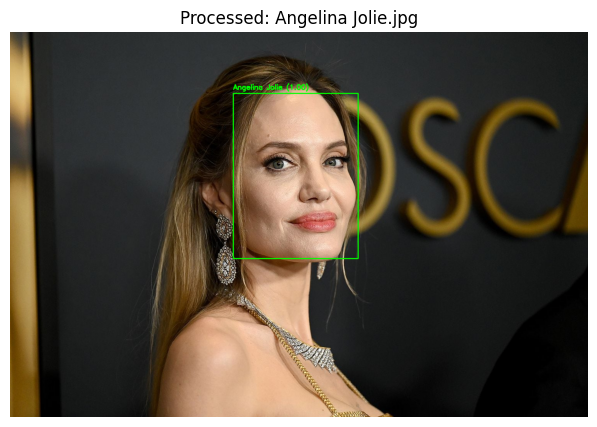


Processing: Brad Pitt.jpg...
 -> Face 0: MATCH Found: Brad Pitt (1.00)


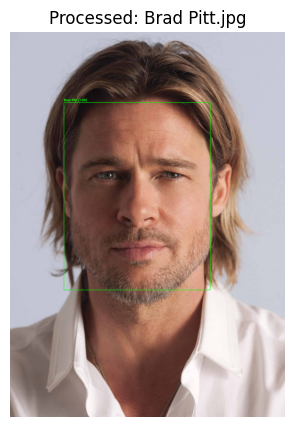


Processing: Leonardo DiCaprio.jpg...
 -> Face 0: MATCH Found: Leonardo DiCaprio (1.00)


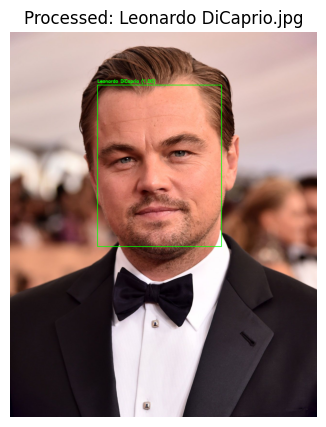


Processing: ss-120921-angelina-jolie-brad-pitt-tease-1036a.today-ss-slide-desktop-4037612162.jpg...
 -> Face 0: MATCH Found: Brad Pitt (0.72)
 -> Face 1: MATCH Found: ss-120921-angelina-jolie-brad-pitt-tease-1036a.today-ss-slide-desktop-4037612162_1 (1.00)
 -> Face 2: MATCH Found: Angelina Jolie (0.63)
 -> Face 3: MATCH Found: ss-120921-angelina-jolie-brad-pitt-tease-1036a.today-ss-slide-desktop-4037612162_3 (1.00)


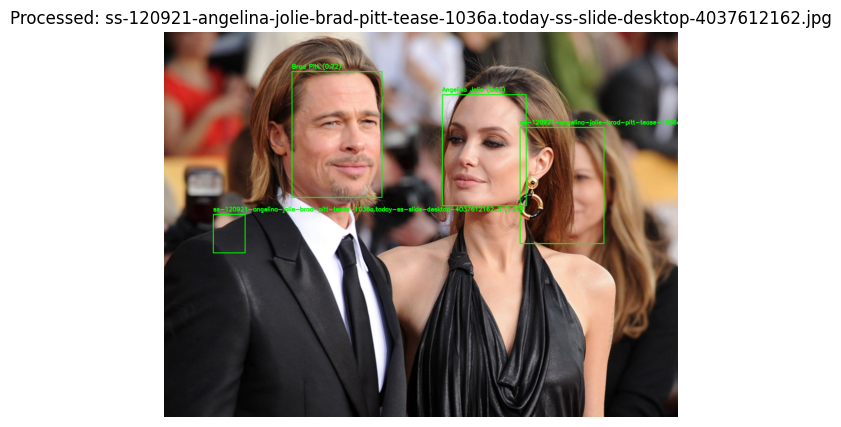


Processing: z_brad_and_leo.jpg...
 -> Face 0: MATCH Found: Leonardo DiCaprio (0.82)
 -> Face 1: MATCH Found: Brad Pitt (0.60)


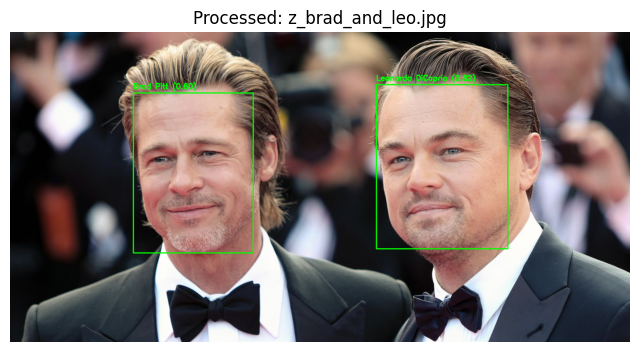

In [8]:
# --- MAIN LOGIC ---

def process_folder():
    # 1. Load DB into memory for fast comparison
    db = load_all_embeddings()
    
    # 2. Get images
    valid_exts = {'.jpg', '.jpeg', '.png'}
    files = [f for f in os.listdir(IMAGES_FOLDER) if os.path.splitext(f)[1].lower() in valid_exts]
    
    if not files:
        print(f"No images found in '{IMAGES_FOLDER}'. Please add some photos!")
        return

    for filename in files:
        filepath = os.path.join(IMAGES_FOLDER, filename)
        print(f"\nProcessing: {filename}...")
        
        # Load Image
        try:
            img = Image.open(filepath)
            if img.mode != 'RGB': img = img.convert('RGB')
        except:
            continue

        # Detect
        boxes, _ = mtcnn.detect(img)
        if boxes is None:
            print(" -> No faces detected.")
            continue

        img_cv = np.array(img)
        input_name = onnx_session.get_inputs()[0].name
        output_name = onnx_session.get_outputs()[0].name

        # Process each face
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.astype(int)
            h, w, _ = img_cv.shape
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            face_crop = img_cv[y1:y2, x1:x2]
            if face_crop.size == 0: continue

            # Preprocess
            face_input = cv2.resize(face_crop, (224, 224), interpolation=cv2.INTER_LANCZOS4)
            face_input = (face_input - 128.0) / 128.0
            face_input = face_input.astype(np.float32)
            face_input = np.transpose(face_input, (2, 0, 1))[np.newaxis, ...]

            # Get Embedding
            curr_embedding = onnx_session.run([output_name], {input_name: face_input})[0][0]

            # Compare
            name, score = find_best_match(curr_embedding, db)

            label = "Unknown"
            color = (255, 0, 0)

            if score > SIMILARITY_THRESHOLD:
                # --- RECOGNIZED ---
                label = f"{name} ({score:.2f})"
                color = (0, 255, 0)
                print(f" -> Face {i}: MATCH Found: {name} ({score:.2f})")
            else:
                # --- NEW PERSON (REGISTER) ---
                # Use filename as name. If multiple faces, append index: angelina_1
                base_name = os.path.splitext(filename)[0]
                new_name = base_name if len(boxes) == 1 else f"{base_name}_{i}"
                
                label = f"New: {new_name}"
                color = (0, 255, 255) # Yellow
                
                print(f" -> Face {i}: New person. Registering as '{new_name}'")
                
                # 1. Save to file immediately
                save_embedding_to_file(new_name, curr_embedding)
                
                # 2. Update memory dict so we recognize them in the NEXT image of this loop
                if new_name not in db: db[new_name] = []
                db[new_name].append(curr_embedding.tolist())

            # Draw
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Visualize
        plt.figure(figsize=(8, 5))
        plt.imshow(img_cv)
        plt.axis('off')
        plt.title(f"Processed: {filename}")
        plt.show()

# Run
process_folder()